# Load and minibatch MNIST data
(c) Deniz Yuret, 2019

* Objective: Learning the structure of the MNIST dataset, usage of the Knet.Data struct and Julia Iterators.
* Prerequisites: Iterators: see [Interfaces](https://docs.julialang.org/en/v1/manual/interfaces/#man-interface-iteration-1),  [Collections](https://docs.julialang.org/en/v1/base/collections/#lib-collections-iteration-1) and [Iteration Utilities](https://docs.julialang.org/en/v1/base/iterators) in the Julia manual.
* Knet: minibatch, mnistview, dir (used and explained)

In [1]:
# Load packages, import symbols
using Pkg; for p in ("Knet","Images","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet: Knet, dir, minibatch, mnistview

In [2]:
# This loads the MNIST handwritten digit recognition dataset:
include(Knet.dir("data","mnist.jl")) 
xtrn,ytrn,xtst,ytst = mnist()
println.(summary.((xtrn,ytrn,xtst,ytst)));

┌ Info: Recompiling stale cache file /home/gridsan/dyuret/.julia/compiled/v1.0/Knet/f4vSz.ji for Knet [1902f260-5fb4-5aff-8c31-6271790ab950]
└ @ Base loading.jl:1190
┌ Info: Loading MNIST...
└ @ Main /home/gridsan/dyuret/.julia/dev/Knet/data/mnist.jl:33


28×28×1×60000 Array{Float32,4}
60000-element Array{UInt8,1}
28×28×1×10000 Array{Float32,4}
10000-element Array{UInt8,1}


In [3]:
# `minibatch` splits the data tensors to small chunks called minibatches
# dtrn contains 600 minibatches of 100 images (total 60000)
# dtst contains 100 minibatches of 100 images (total 10000)
dtrn = minibatch(xtrn,ytrn,100)
dtst = minibatch(xtst,ytst,100)
length.((dtrn,dtst))

(600, 100)

In [4]:
# Each minibatch is an (x,y) pair where x is 100 28x28x1 images and y are the labels.
# Here is the first minibatch in the test set:
(x,y) = first(dtst)
summary.((x,y))

("28×28×1×100 Array{Float32,4}", "100-element Array{UInt8,1}")

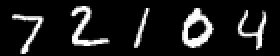

In [5]:
# Here is the first five images from the test set:
using Images
hcat([mnistview(x,i) for i=1:5]...)

In [6]:
# Here are their labels (10 is used to represent 0)
println(Int.(y[1:5]));

[7, 2, 1, 10, 4]


# Iterators

The `minibatch` function returns `dtrn` and `dtst` implemented as Julia iterators. These are lazy objects that only generate their next element when asked. This has the advantage of not wasting memory trying to store all the minibatches. We can even have infinite data generators! Here are some things Julia can do with iterators:

In [7]:
using Base.Iterators: take, drop, cycle, Stateful

In [8]:
# Iterators can be used in for loops
# Let's count the elements in dtst:
n = 0
for (x,y) in dtst; n += 1; end
@show n;

n = 100


In [9]:
# Iterators can be converted to arrays using `collect` 
# (don't do this unless necessary, it just wastes memory. Use a for loop instead)
collect(dtst) |> summary

"100-element Array{Tuple{Array{Float32,4},Array{UInt8,1}},1}"

In [10]:
# We can generate an iterator for multiple epochs using `repeat`
# (an epoch is a single pass over the dataset)
n = 0
for (x,y) in repeat(dtst,5); n += 1; end
@show n;

n = 500


In [11]:
# We can generate partial epochs using `take` which takes the first n elements
n = 0
for (x,y) in take(dtst,20); n += 1; end
@show n;

n = 20


In [12]:
# We can also generate partial epochs using `drop` which drops the first n elements
n = 0
for (x,y) in drop(dtst,20); n += 1; end
@show n;

n = 80


In [13]:
# We can repeat forever using `cycle` (this is useful to train until convergence)
# You do not want to collect a cycle or run a for loop without break! 
n = 0; t = time_ns()
for (x,y) in cycle(dtst)
    n += 1
    time_ns() - t > 2e9 && break # Break after 2 seconds
end
@show n;

n = 19831


In [14]:
# We can make an iterator `Stateful` so it remembers where it left off.
# (by default iterators start from the beginning)
dtst1 = dtst            # dtst1 will start from beginning every time
dtst2 = Stateful(dtst)  # dtst2 will remember where we left off
for (x,y) in dtst1; println(Int.(y[1:5])); break; end
for (x,y) in dtst1; println(Int.(y[1:5])); break; end
for (x,y) in dtst2; println(Int.(y[1:5])); break; end
for (x,y) in dtst2; println(Int.(y[1:5])); break; end

[7, 2, 1, 10, 4]
[7, 2, 1, 10, 4]
[7, 2, 1, 10, 4]
[6, 10, 5, 4, 9]


In [15]:
# We can shuffle instances at every epoch using the keyword argument `shuffle=true`
# (by default elements are generated in the same order)
dtst1 = minibatch(xtst,ytst,100)              # dtst1 iterates in the same order
dtst2 = minibatch(xtst,ytst,100,shuffle=true) # dtst2 shuffles each time
for (x,y) in dtst1; println(Int.(y[1:5])); break; end
for (x,y) in dtst1; println(Int.(y[1:5])); break; end
for (x,y) in dtst2; println(Int.(y[1:5])); break; end
for (x,y) in dtst2; println(Int.(y[1:5])); break; end

[7, 2, 1, 10, 4]
[7, 2, 1, 10, 4]
[7, 1, 2, 9, 10]
[10, 9, 10, 10, 1]


In [16]:
# Every iterator implements the `iterate` function which returns
# the next element and state (or nothing if no elements left).
# Here is how the for loop for dtst is implemented:
n = 0; next = iterate(dtst)
while next != nothing
    ((x,y), state) = next
    n += 1
    next = iterate(dtst,state)
end
@show n;

n = 100


In [17]:
# You can define your own iterator by defining an `iterate` method.
# Here is an iterator that computes sum(abs2,x) for each minibatch:
struct Xnorm; itr; end

function Base.iterate(f::Xnorm, s...)
    next = iterate(f.itr, s...)
    next === nothing && return nothing
    ((x,y),state) = next
    return sum(abs2,x), state
end

Base.length(f::Xnorm) = length(f.itr) # collect needs this

collect(Xnorm(dtrn))'

1×600 LinearAlgebra.Adjoint{Any,Array{Any,1}}:
 8464.93  8514.65  8632.75  8385.32  …  9034.64  8812.92  10116.4  7348.92

In [18]:
# The same result can be more compactly obtained using [Generator expressions](https://docs.julialang.org/en/v1/manual/arrays/#Generator-Expressions-1)
xnorm(data) = (sum(abs2,x) for (x,y) in data)
collect(xnorm(dtrn))'

1×600 LinearAlgebra.Adjoint{Float32,Array{Float32,1}}:
 8464.93  8514.65  8632.75  8385.32  …  9034.64  8812.92  10116.4  7348.92